In [ ]:
import urllib3
from sklearn import preprocessing
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
#import urllib.request
import json
import os
import re
import datetime
import shutil
import matplotlib.pyplot as plt
import matplotlib
import sys
%matplotlib inline
#http://data.coa.gov.tw/Service/OpenData/FromM/FarmTransData.aspx?Market=台北二&StartDate=107.01.01&EndDate=108.03.20&Crop=甘藍-初秋
path_to_veg_and_fruits_api = 'http://data.coa.gov.tw/Service/OpenData/FromM/FarmTransData.aspx'
queryfields = {'Market': '台北二'}
need_vegs = ['甘藍-初秋','包心白菜-包白','小白菜-蚵仔白','青江白菜-小梗','蕹菜-小葉','甘藷葉','菠菜-圓葉']
http = urllib3.PoolManager()

In [30]:
cropdata = {}
cropdata_df = {}
for crop in need_vegs:
    for monthi in range(1,13):
        queryfields['StartDate'] = str('107.')+str("%02d" % monthi)+".01"
        queryfields['EndDate'] = str('107.')+str("%02d" % (monthi+1))+".01"
        queryfields['Crop'] = crop
        if (monthi==12):
            queryfields['EndDate'] = str('107.')+str("%02d" % monthi)+".31"
        request = http.request_encode_url('GET',path_to_veg_and_fruits_api, fields=queryfields)
        print("Done fetching"+crop+queryfields['StartDate'])
        cropdata_key = crop+queryfields['StartDate']
        cropdata[cropdata_key] = json.loads(request.data.decode('utf-8'))
        cropdata_df[cropdata_key] = json_normalize(cropdata[cropdata_key])

finalcropdf = pd.concat(cropdata_df).drop_duplicates().sort_values(by=['作物名稱','交易日期'])
finalcropdf.head()

Done fetching甘藍-初秋107.01.01
Done fetching甘藍-初秋107.02.01
Done fetching甘藍-初秋107.03.01
Done fetching甘藍-初秋107.04.01
Done fetching甘藍-初秋107.05.01
Done fetching甘藍-初秋107.06.01
Done fetching甘藍-初秋107.07.01
Done fetching甘藍-初秋107.08.01
Done fetching甘藍-初秋107.09.01
Done fetching甘藍-初秋107.10.01
Done fetching甘藍-初秋107.11.01
Done fetching甘藍-初秋107.12.01
Done fetching包心白菜-包白107.01.01
Done fetching包心白菜-包白107.02.01
Done fetching包心白菜-包白107.03.01
Done fetching包心白菜-包白107.04.01
Done fetching包心白菜-包白107.05.01
Done fetching包心白菜-包白107.06.01
Done fetching包心白菜-包白107.07.01
Done fetching包心白菜-包白107.08.01
Done fetching包心白菜-包白107.09.01
Done fetching包心白菜-包白107.10.01
Done fetching包心白菜-包白107.11.01
Done fetching包心白菜-包白107.12.01
Done fetching小白菜-蚵仔白107.01.01
Done fetching小白菜-蚵仔白107.02.01
Done fetching小白菜-蚵仔白107.03.01
Done fetching小白菜-蚵仔白107.04.01
Done fetching小白菜-蚵仔白107.05.01
Done fetching小白菜-蚵仔白107.06.01
Done fetching小白菜-蚵仔白107.07.01
Done fetching小白菜-蚵仔白107.08.01
Done fetching小白菜-蚵仔白107.09.01
Done fetching小白菜-蚵仔白107.10.01
Done

上價   下價   中價       交易日期  交易量  作物代號 作物名稱 市場代號 市場名稱  平均價
包心白菜-包白107.01.01 31  0.0  0.0  0.0  107.01.01  0.0  rest   休市  104  台北二  0.0
                 24  0.0  0.0  0.0  107.01.08  0.0  rest   休市  104  台北二  0.0
                 17  0.0  0.0  0.0  107.01.15  0.0  rest   休市  104  台北二  0.0
                 10  0.0  0.0  0.0  107.01.22  0.0  rest   休市  104  台北二  0.0
                 3   0.0  0.0  0.0  107.01.29  0.0  rest   休市  104  台北二  0.0

In [31]:
finalcropdf = finalcropdf[finalcropdf['作物名稱'].str.contains('休市') != True]
finalcropdf = finalcropdf.filter(items=['平均價', '交易日期','作物名稱'])
def registerdt_to_timestamp(x):
    #format is'107.01.29'
    year = int(x[0:3])
    month = int(x[4:6])
    day = int(x[7:9])
    return(datetime.datetime(2018, month, day, 0, 0, 0).timestamp()/60/60/24)
registerdt_to_timestamp = np.vectorize(registerdt_to_timestamp)
finalcropdf = finalcropdf.assign(timestamp=registerdt_to_timestamp(finalcropdf["交易日期"]))

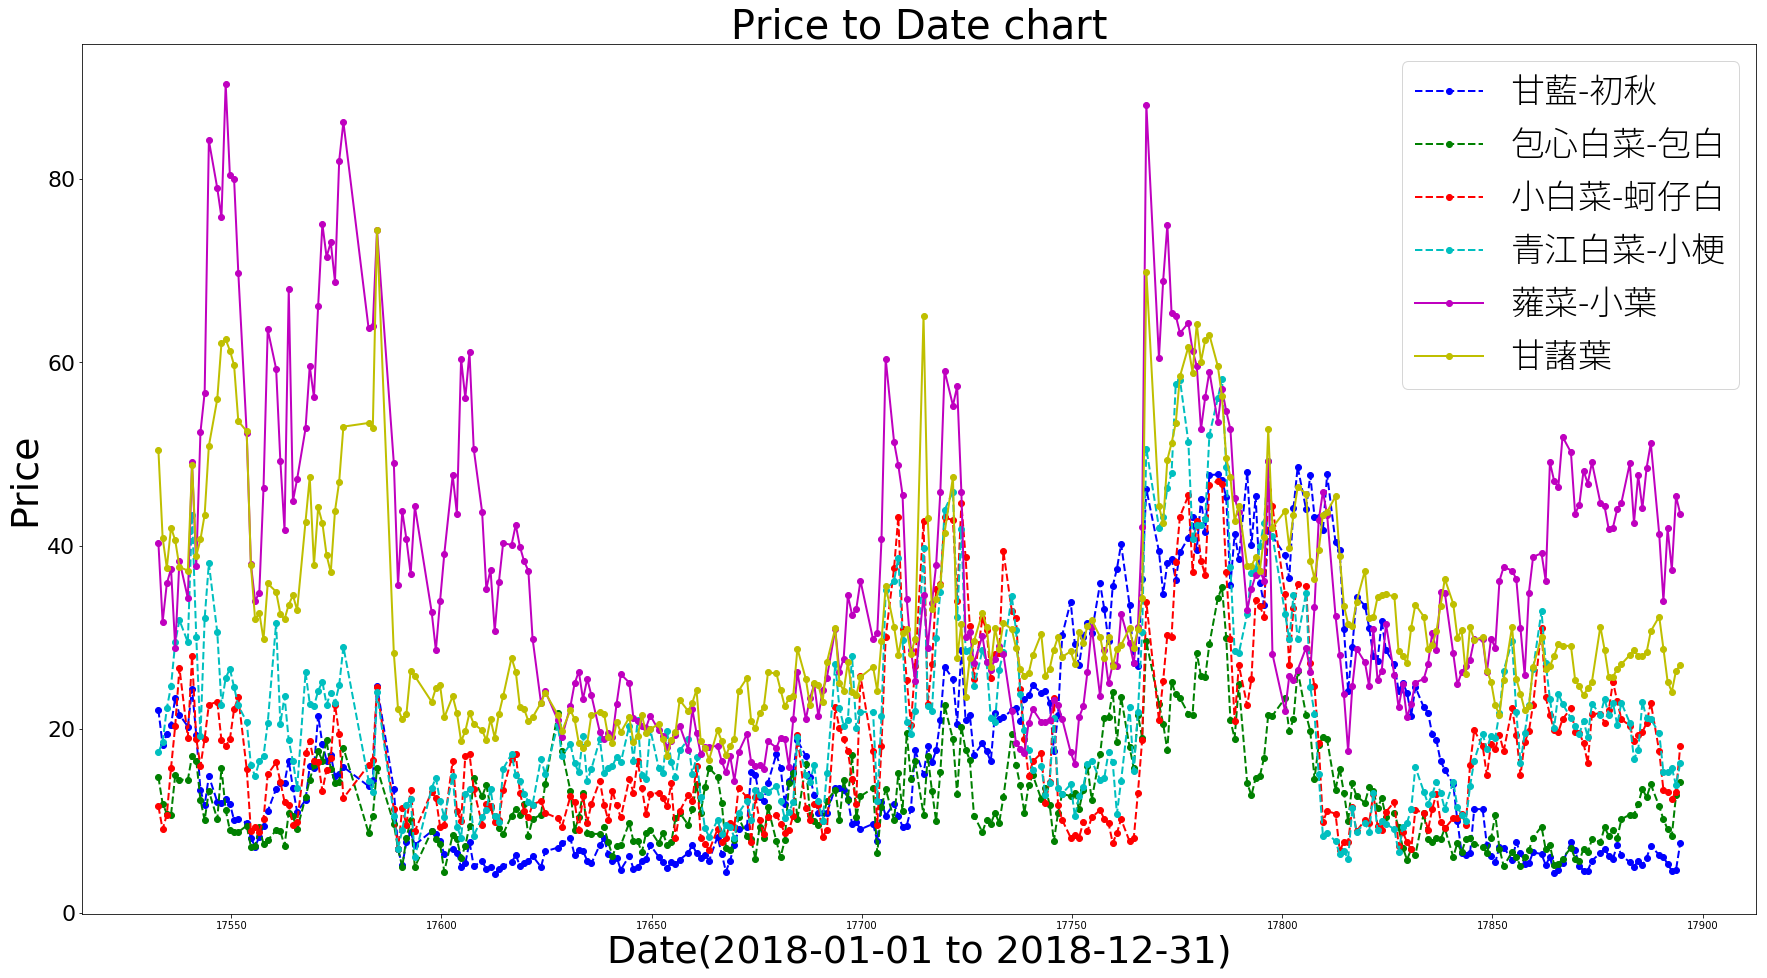

In [32]:
linecolors = ['b--o','g--o','r--o','c--o','m-o','y-o','k-o','#ff33cc','#cc9900']
chinese_font = matplotlib.font_manager.FontProperties(fname='/home/j/pythonscripts/SourceHanSans-Medium.ttc',size='34')
plt.figure(figsize=(30, 16))
plt.title('Price to Date chart', fontdict={'fontsize':40})
for need_vegs_i in range(0,len(need_vegs)):
    crop = need_vegs[need_vegs_i]
    plt.xlabel("Date(2018-01-01 to 2018-12-31)", fontsize=38)
    plt.ylabel("Price", fontsize=38)
    childcropdf = finalcropdf[finalcropdf.作物名稱 == crop]
    crop_timestamp = np.array(childcropdf["timestamp"])
    crop_price = np.array(childcropdf["平均價"])
    plt.plot(crop_timestamp, crop_price, linecolors[need_vegs_i], label=crop, linewidth=2)
legend = plt.legend(need_vegs, prop=chinese_font)
plt.yticks(size = 22)
plt.show()